In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import os
import json
import math
from sklearn.model_selection import KFold

sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.2, rc={'lines.markersize': 8})

In [2]:
folds = 6
indexes = list(range(48))
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
kf.get_n_splits(indexes)

FOLD_DICT = {k+1: list(v[1]+1) for k, v in enumerate(list(kf.split(indexes)))}

In [3]:
FOLD_DICT

{1: [13, 20, 25, 27, 28, 38, 41, 44],
 2: [4, 5, 7, 9, 14, 26, 34, 40],
 3: [10, 16, 17, 18, 30, 33, 46, 47],
 4: [1, 2, 6, 12, 31, 32, 35, 45],
 5: [3, 11, 22, 23, 24, 36, 37, 42],
 6: [8, 15, 19, 21, 29, 39, 43, 48]}

In [4]:
def get_quality_counts(qualities):
    return [qualities.count(1), qualities.count(2)]

In [5]:
K = -1
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_{variant}mbps_lpoa_mult'.format(K=K, variant='{variant}')
VIDEO_LIST = [0,2,4]
VIDEO_TITLES = ['Sandwich', 'Spotlight', 'Surf']
# USER_LIST = range
# QUALITIES = [1, 2, 3, 4, 5]
TIME_FILE_TMPL = 'log_seg_u{user}_prefetch.txt'
NP_TIME_FILE_TMPL = 'log_seg_u{user}_no_prefetch.txt'
QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_prefetch.txt'
NP_QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_no_prefetch.txt'
FREEZES_FILE_TMPL = 'log_seg_freezes_u{user}_prefetch.txt'
NP_FREEZES_TIME_FILE_TMPL = 'log_seg_freezes_u{user}_no_prefetch.txt'
# VARIANTS = {'dyn_vp_cc': 'NCP', 'dyn_vp_hw': 'HWP', 'dyn_vp_sc': 'NSP'}
VARIANTS = range(10,55,5)
# THRESHOLDS = [90]
SEG_DUR = 1.065

results_list = []
prefetch_flag = False

for var in VARIANTS:
#     for th in THRESHOLDS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for (times_tmpl, qualities_tmpl, freezes_tmpl) in [(TIME_FILE_TMPL, QUALITY_FILE_TMPL, FREEZES_FILE_TMPL), (NP_TIME_FILE_TMPL, NP_QUALITY_FILE_TMPL, NP_FREEZES_TIME_FILE_TMPL)]:
                    prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{qualities_tmpl.format(user=u)}', 'r') as q_file:
                        p_qualities = [get_quality_counts([int(x) for x in json.loads(line)]) for line in q_file]
                        p_df = pd.DataFrame(p_qualities, columns=['lq', 'hq'])
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{freezes_tmpl.format(user=u)}', 'r') as f_file:
                        p_n_freezes, p_freezes_dur = (float(i) for i in f_file.readline().split(', '))
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as t_file:
                        p_times, p_bandwidth = zip(*[(float(t.split(', ')[0].strip()), float(t.split(', ')[1].strip())) for t in t_file.readlines()])
#                             p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'bitrate', 'threshold', 'seg_resp_time'])
                        p_df['seg_resp_time'] = p_times
                        p_df['perceived_bandwidth'] = np.array(p_bandwidth)/1000000.
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = VIDEO_TITLES[int(v/2)]
                        p_df['user'] = u
                        p_df['prefetch'] = 'PREFETCH' if prefetch_flag else f'NO_PREFETCH'
                        p_df['bitrate'] = var
#                         p_df['threshold'] = th
                        p_df['n_freezes'] = p_n_freezes
                        p_df['freezes_dur'] = p_freezes_dur
                        p_df['hq_ratio'] = p_df.apply(lambda r: r.hq/(r.hq + r.lq), axis=1)
                        p_df['lq_ratio'] = 1 - p_df['hq_ratio']
                        results_list.append(p_df)
                


In [6]:
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_{variant}mbps_lru_mult'.format(K=K, variant='{variant}')

# results_list = []
prefetch_flag = True

for var in VARIANTS:
#     for th in THRESHOLDS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for (times_tmpl, qualities_tmpl, freezes_tmpl) in [(TIME_FILE_TMPL, QUALITY_FILE_TMPL, FREEZES_FILE_TMPL)]:
#                     prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{qualities_tmpl.format(user=u)}', 'r') as q_file:
                        p_qualities = [get_quality_counts([int(x) for x in json.loads(line)]) for line in q_file]
                        p_df = pd.DataFrame(p_qualities, columns=['lq', 'hq'])
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{freezes_tmpl.format(user=u)}', 'r') as f_file:
                        p_n_freezes, p_freezes_dur = (float(i) for i in f_file.readline().split(', '))
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as t_file:
                        p_times, p_bandwidth = zip(*[(float(t.split(', ')[0].strip()), float(t.split(', ')[1].strip())) for t in t_file.readlines()])
#                             p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'bitrate', 'threshold', 'seg_resp_time'])
                        p_df['seg_resp_time'] = p_times
                        p_df['perceived_bandwidth'] = np.array(p_bandwidth)/1000000.
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = VIDEO_TITLES[int(v/2)]
                        p_df['user'] = u
                        p_df['prefetch'] = 'LRU' if prefetch_flag else f'NO_PREFETCH'
                        p_df['bitrate'] = var
#                         p_df['threshold'] = th
                        p_df['n_freezes'] = p_n_freezes
                        p_df['freezes_dur'] = p_freezes_dur
                        p_df['hq_ratio'] = p_df.apply(lambda r: r.hq/(r.hq + r.lq), axis=1)
                        p_df['lq_ratio'] = 1 - p_df['hq_ratio']
                        results_list.append(p_df)
                
# results_lru_df = pd.concat(results_list, ignore_index=True)

In [7]:
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_{variant}mbps_lq_mult'.format(K=K, variant='{variant}')

# results_list = []
prefetch_flag = True

for var in VARIANTS:
#     for th in THRESHOLDS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for (times_tmpl, qualities_tmpl, freezes_tmpl) in [(TIME_FILE_TMPL, QUALITY_FILE_TMPL, FREEZES_FILE_TMPL)]:
#                     prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{qualities_tmpl.format(user=u)}', 'r') as q_file:
                        p_qualities = [get_quality_counts([int(x) for x in json.loads(line)]) for line in q_file]
                        p_df = pd.DataFrame(p_qualities, columns=['lq', 'hq'])
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{freezes_tmpl.format(user=u)}', 'r') as f_file:
                        p_n_freezes, p_freezes_dur = (float(i) for i in f_file.readline().split(', '))
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as t_file:
                        p_times, p_bandwidth = zip(*[(float(t.split(', ')[0].strip()), float(t.split(', ')[1].strip())) for t in t_file.readlines()])
#                             p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'bitrate', 'threshold', 'seg_resp_time'])
                        p_df['seg_resp_time'] = p_times
                        p_df['perceived_bandwidth'] = np.array(p_bandwidth)/1000000.
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = VIDEO_TITLES[int(v/2)]
                        p_df['user'] = u
                        p_df['prefetch'] = 'PREFETCH_LQ_ONLY' if prefetch_flag else f'NO_PREFETCH'
                        p_df['bitrate'] = var
#                         p_df['threshold'] = th
                        p_df['n_freezes'] = p_n_freezes
                        p_df['freezes_dur'] = p_freezes_dur
                        p_df['hq_ratio'] = p_df.apply(lambda r: r.hq/(r.hq + r.lq), axis=1)
                        p_df['lq_ratio'] = 1 - p_df['hq_ratio']
                        results_list.append(p_df)
                
# results_lru_df = pd.concat(results_list, ignore_index=True)

In [8]:
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_{variant}mbps_hq_mult'.format(K=K, variant='{variant}')

# results_list = []
prefetch_flag = True

for var in VARIANTS:
#     for th in THRESHOLDS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for (times_tmpl, qualities_tmpl, freezes_tmpl) in [(TIME_FILE_TMPL, QUALITY_FILE_TMPL, FREEZES_FILE_TMPL)]:
#                     prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{qualities_tmpl.format(user=u)}', 'r') as q_file:
                        p_qualities = [get_quality_counts([int(x) for x in json.loads(line)]) for line in q_file]
                        p_df = pd.DataFrame(p_qualities, columns=['lq', 'hq'])
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{freezes_tmpl.format(user=u)}', 'r') as f_file:
                        p_n_freezes, p_freezes_dur = (float(i) for i in f_file.readline().split(', '))
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as t_file:
                        p_times, p_bandwidth = zip(*[(float(t.split(', ')[0].strip()), float(t.split(', ')[1].strip())) for t in t_file.readlines()])
#                             p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'bitrate', 'threshold', 'seg_resp_time'])
                        p_df['seg_resp_time'] = p_times
                        p_df['perceived_bandwidth'] = np.array(p_bandwidth)/1000000.
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = VIDEO_TITLES[int(v/2)]
                        p_df['user'] = u
                        p_df['prefetch'] = 'PREFETCH_HQ_ONLY' if prefetch_flag else f'NO_PREFETCH'
                        p_df['bitrate'] = var
#                         p_df['threshold'] = th
                        p_df['n_freezes'] = p_n_freezes
                        p_df['freezes_dur'] = p_freezes_dur
                        p_df['hq_ratio'] = p_df.apply(lambda r: r.hq/(r.hq + r.lq), axis=1)
                        p_df['lq_ratio'] = 1 - p_df['hq_ratio']
                        results_list.append(p_df)
                
# results_lru_df = pd.concat(results_list, ignore_index=True)

In [9]:
results_df = pd.concat(results_list, ignore_index=True)

In [10]:
results_df

,lq,hq,seg_resp_time,perceived_bandwidth,segment,video,user,prefetch,bitrate,n_freezes,freezes_dur,hq_ratio,lq_ratio
0,16,0,0.183813,0.741971,1,Sandwich,13,PREFETCH,10,0.0,0.00000,0.0000,1.0000
1,16,0,0.249167,1.162625,2,Sandwich,13,PREFETCH,10,0.0,0.00000,0.0000,1.0000
2,16,0,0.322141,3.477310,3,Sandwich,13,PREFETCH,10,0.0,0.00000,0.0000,1.0000
3,16,0,0.406757,4.061960,4,Sandwich,13,PREFETCH,10,0.0,0.00000,0.0000,1.0000
4,13,3,0.641409,5.584309,5,Sandwich,13,PREFETCH,10,0.0,0.00000,0.1875,0.8125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194395,16,0,1.099259,1.129109,26,Surf,48,PREFETCH_HQ_ONLY,50,29.0,5.70208,0.0000,1.0000
194396,16,0,1.117503,1.057708,27,Surf,48,PREFETCH_HQ_ONLY,50,29.0,5.70208,0.0000,1.0000
194397,16,0,1.204092,1.119018,28,Surf,48,PREFETCH_HQ_ONLY,50,29.0,5.70208,0.0000,1.0000
194398,16,0,1.245600,1.249698,29,Surf,48,PREFETCH_HQ_ONLY,50,29.0,5.70208,0.0000,1.0000


In [11]:
results_df['freeze_to_playback'] = round(results_df['freezes_dur'] / (30 * SEG_DUR), 2)

In [12]:
# k_unique = results_df['k'].unique().tolist()
v_unique = results_df['video'].unique().tolist()

In [13]:
list(range(0, len(VARIANTS), 2))

[0, 2, 4, 6, 8]

PREFETCH: 0.0763888888888889
NO_PREFETCH: 0.015277777777777776
LRU: 0.1375


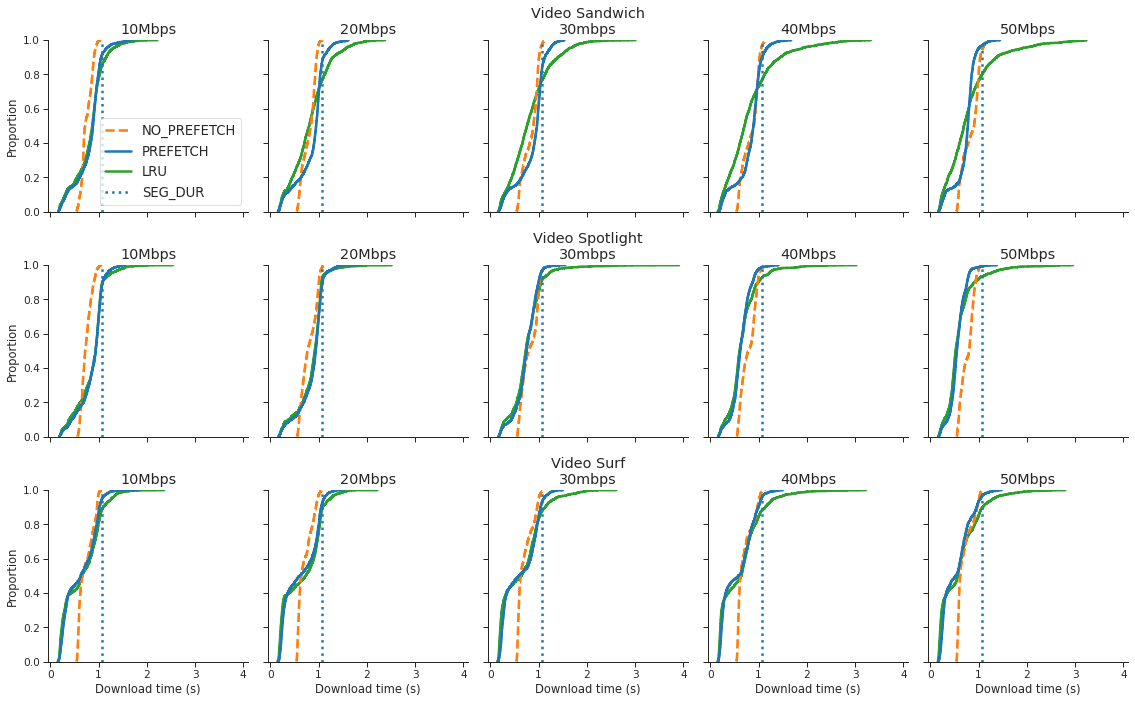

In [14]:
fig, axes = plt.subplots(len(v_unique), math.ceil(len(VARIANTS)/2), figsize=(16,10), sharex=True, sharey=True)
th = 90

sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.5, rc={'lines.markersize': 8})

acc_prefetch = 0.0
acc_lru = 0.0
acc_no_prefetch = 0.0

results_df_filtered = results_df[~results_df['prefetch'].isin(['PREFETCH_LQ_ONLY', 'PREFETCH_HQ_ONLY'])].copy()

for i in range(len(v_unique)):
    for j in range(math.ceil(len(VARIANTS)/2)):
        axis = axes[i][j]
#         axis = axes[j]
        sns.ecdfplot(
            data=results_df_filtered[(results_df_filtered['video'] == v_unique[i]) & (results_df_filtered['bitrate'] == VARIANTS[j*2])], 
            x="seg_resp_time", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True,
            ax=axis
        )
        sns.despine()

        axis.lines[1].set_linestyle("--")
        leg = axis.get_legend()
        leg_texts = [t.get_text() for t in leg.texts]
        leg.get_lines()[leg_texts.index(f'NO_PREFETCH')].set_linestyle("--")
        axis.set_title(f'Video {VIDEO_TITLES[i]}\n{VARIANTS[j*2]}mbps' if j==int(len(VARIANTS)/4) else f'{VARIANTS[j*2]}Mbps')
        axis.axvline(x=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
#         axis.set_title(f'Video {j*2}')
        axis.set_xlabel('Download time (s)')
#         axis.set_ylabel('Download time (s)')
        axis.get_legend().set_title("")
        axis.legend(
            handles=[axis.lines[1], axis.lines[2], axis.lines[0], axis.lines[3]],#, axis.lines[0], axis.lines[4]], 
            labels=["NO_PREFETCH", f"PREFETCH", "LRU", "SEG_DUR"]#, f"HWP_{THRESHOLDS[i]}", f"NSP_{THRESHOLDS[i]}", "SEG_DUR"]
        )
        if j != 0 or i != 0:
            axis.get_legend().remove()
#         print(f'video: {v_unique[i]} | bitrate: {VARIANTS[j*2]}')
        filtered_df = results_df_filtered[(results_df_filtered['video'] == v_unique[i]) & (results_df_filtered['bitrate'] == VARIANTS[j*2])].copy()
        acc_prefetch += filtered_df[(filtered_df['seg_resp_time'] >= SEG_DUR) & (filtered_df['prefetch'] == 'PREFETCH')].shape[0]/filtered_df[filtered_df['prefetch'] == 'PREFETCH'].shape[0]
        acc_no_prefetch += filtered_df[(filtered_df['seg_resp_time'] >= SEG_DUR) & (filtered_df['prefetch'] == 'NO_PREFETCH')].shape[0]/filtered_df[filtered_df['prefetch'] == 'NO_PREFETCH'].shape[0]
        acc_lru += filtered_df[(filtered_df['seg_resp_time'] >= SEG_DUR) & (filtered_df['prefetch'] == 'LRU')].shape[0]/filtered_df[filtered_df['prefetch'] == 'LRU'].shape[0]
#         print(f"PREFETCH: {filtered_df[(filtered_df['seg_resp_time'] > SEG_DUR) & (filtered_df['prefetch'] == 'PREFETCH')].shape[0]/filtered_df[filtered_df['prefetch'] == 'PREFETCH'].shape[0]}")
#         display(filtered_df[(filtered_df['prefetch'] == 'PREFETCH')].describe()['seg_resp_time'])
#         print(f"LRU: {filtered_df[(filtered_df['seg_resp_time'] > SEG_DUR) & (filtered_df['prefetch'] == 'LRU')].shape[0]/filtered_df[filtered_df['prefetch'] == 'LRU'].shape[0]}")
#         display(filtered_df[(filtered_df['prefetch'] == 'LRU')].describe()['seg_resp_time'])
        
    #     axis.set_xlim(0,2.5)

print(f'PREFETCH: {acc_prefetch/15}')
print(f'NO_PREFETCH: {acc_no_prefetch/15}')
print(f'LRU: {acc_lru/15}')
# plt.suptitle(f'ECDF Download time per segment')
plt.tight_layout()

In [15]:
fig.savefig('ecdf-download-time.pdf', format='pdf', dpi=300, bbox_inches='tight')

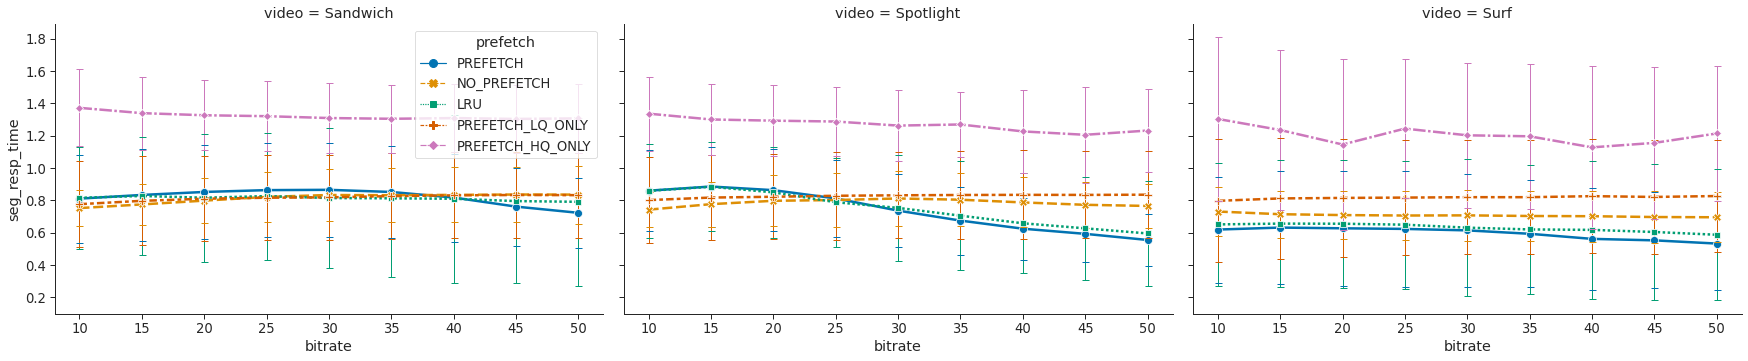

In [16]:
sns.relplot(x="bitrate", y="seg_resp_time", 
            kind="line", palette='colorblind', col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci='sd', markers=True, style='prefetch', hue='prefetch', linewidth=2.5, 
            data=results_df, height=5, aspect=1.618, facet_kws = {'legend_out': False})

# sns.lineplot(x="bitrate", y="seg_resp_time", hue="prefetch", data=results_df, err_style='bars', elinewidth=1.0, capsize= 3.5)

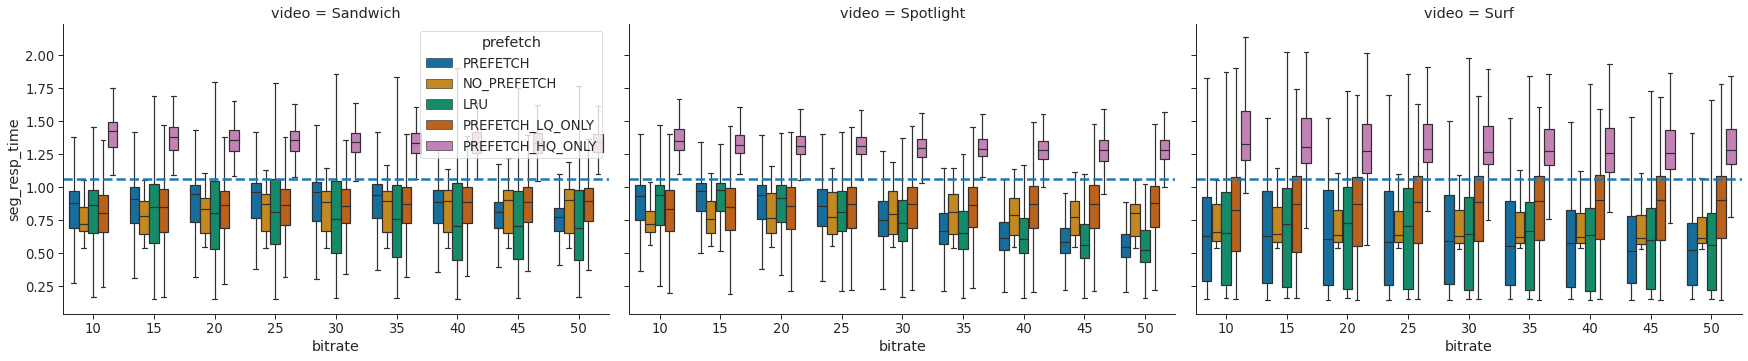

In [17]:
g = sns.catplot(x="bitrate", y="seg_resp_time", 
            kind="box", palette='colorblind',
            hue='prefetch', data=results_df, 
            height=5, aspect=1.618, showfliers=False,
            legend_out=False, col='video')

for ax in g.axes.flat:
    ax.axhline(y=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle="--")

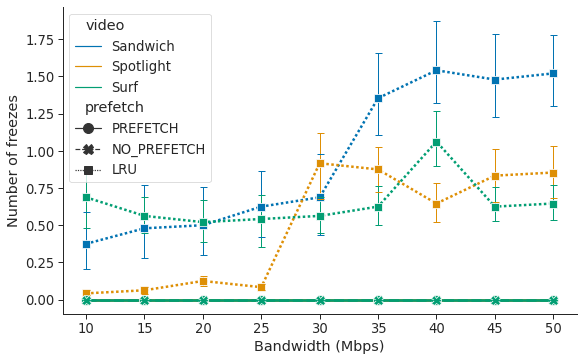

In [18]:
sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.5, rc={'lines.markersize': 10})
g = sns.relplot(x="bitrate", y="n_freezes", 
            kind="line", palette='colorblind', hue='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=99.999, markers=True, style='prefetch', linewidth=2.5, # ci=68: Standard error of the mean
            data=results_df_filtered, height=5, aspect=1.618, facet_kws = {'legend_out': False})
g.set(ylabel='Number of freezes', xlabel='Bandwidth (Mbps)')

In [19]:
g.savefig('num-freezes.pdf', format='pdf', dpi=300, bbox_inches='tight')

<ipython-input-20-802f5cf3c0cf>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


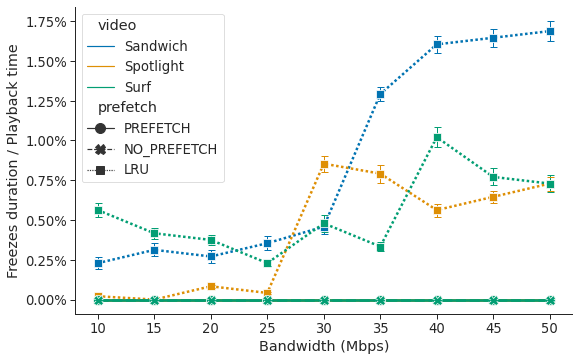

In [20]:
g = sns.relplot(x="bitrate", y="freeze_to_playback", 
            kind="line", palette='colorblind', hue='video',#col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=68, markers=True, style='prefetch', linewidth=2.5, # ci=68: Standard error of the mean
            data=results_df_filtered, height=5, aspect=1.618, facet_kws = {'legend_out': False})
g.set(ylabel='Freezes duration / Playback time', xlabel='Bandwidth (Mbps)')

for ax in g.axes.flat:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

In [21]:
g.savefig('dur-freezes.pdf', format='pdf', dpi=300, bbox_inches='tight')

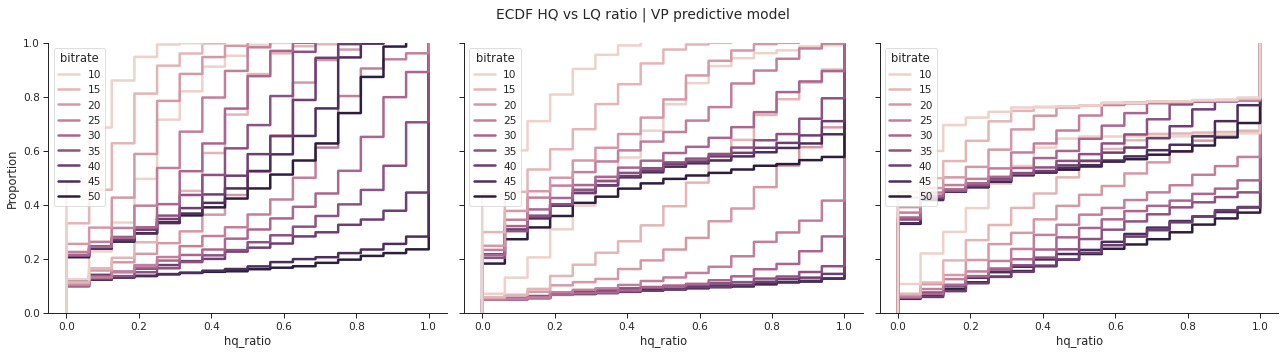

In [22]:
sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.2, rc={'lines.markersize': 8})
fig, axes = plt.subplots(1, len(v_unique), figsize=(18,5), sharex=True, sharey=True)

for i in range(len(v_unique)):
#     for j in range(len(VARIANTS)):
#         axis = axes[i][j]
    axis = axes[i]
    sns.ecdfplot(
        data=results_df_filtered[(results_df_filtered['video'] == v_unique[i]) & (results_df_filtered['prefetch'] == 'PREFETCH')], 
        x="hq_ratio", 
        linewidth=2.5, 
        hue="bitrate",
        legend=True,
        ax=axis
    )
    sns.ecdfplot(
        data=results_df_filtered[(results_df_filtered['video'] == v_unique[i]) & (results_df_filtered['prefetch'] == 'NO_PREFETCH')], 
        x="hq_ratio", 
        linewidth=2.5, 
        hue="bitrate",
        legend=True,
        ax=axis
    )
    sns.despine()

#         axis.lines[0].set_linestyle("--")
#         leg = axis.get_legend()
#         leg_texts = [t.get_text() for t in leg.texts]
#         leg.get_lines()[leg_texts.index(f'NO_PREFETCH')].set_linestyle("--")
#         axis.set_title(f'Video {VIDEO_TITLES[i]}\n{VARIANTS[j]}mbps' if j==int(len(VARIANTS)/2) else f'{VARIANTS[j]}mbps')
#         axis.axhline(y=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
# #         axis.set_title(f'Video {j*2}')
#         axis.set_ylabel('Download time (s)')
#         axis.get_legend().set_title("")
#         axis.legend(
#             handles=[axis.lines[0], axis.lines[1], axis.lines[2]],#, axis.lines[0], axis.lines[4]], 
#             labels=["NO_PREFETCH", f"PREFETCH", "SEG_DUR"]#, f"HWP_{THRESHOLDS[i]}", f"NSP_{THRESHOLDS[i]}", "SEG_DUR"]
#         )
    #     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF HQ vs LQ ratio | VP predictive model')
plt.tight_layout()

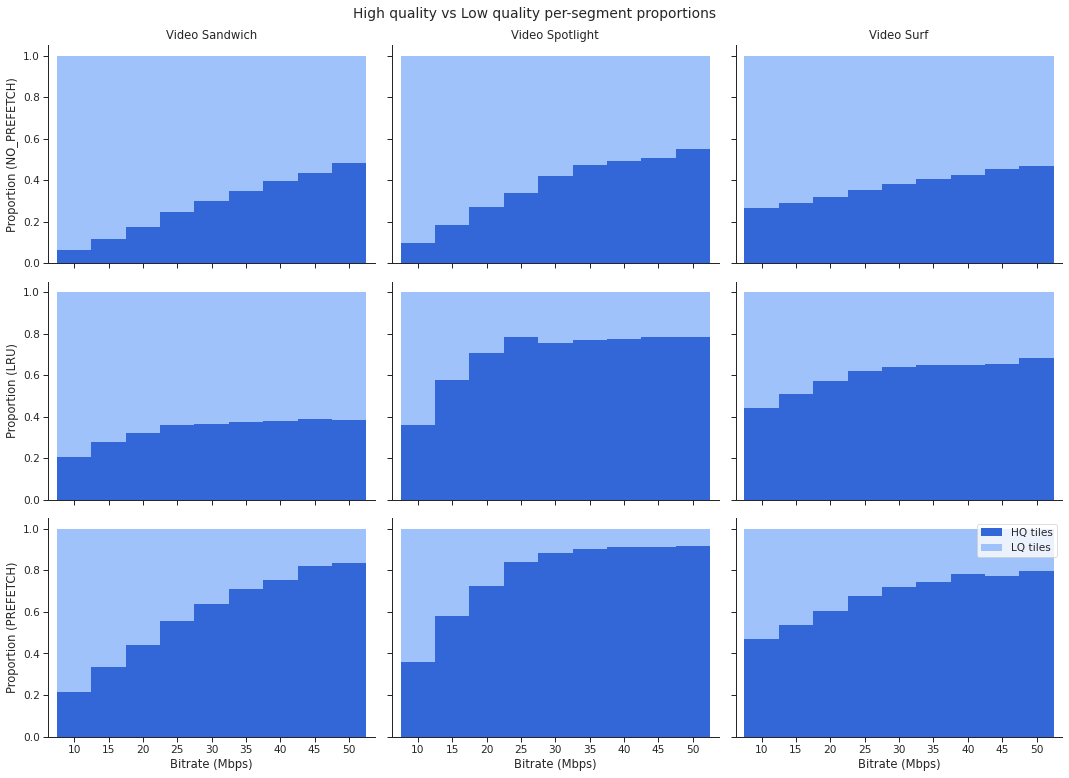

In [23]:
fig, axes = plt.subplots(3, len(v_unique), figsize=(15,11), sharex=True, sharey=True)
prefetch_labels = ['NO_PREFETCH', 'LRU', 'PREFETCH']
hq_lq_ratio_df = results_df_filtered[['video', 'bitrate', 'prefetch', 'hq_ratio', 'lq_ratio']].groupby(['video', 'prefetch', 'bitrate']).mean().reset_index()

for i in range(3):
    for j in range(len(v_unique)):
        axis = axes[i][j]
#         axis = axes[i]
        hq_lq_ratio_df[(hq_lq_ratio_df['video'] == v_unique[j]) & (hq_lq_ratio_df['prefetch'] == prefetch_labels[i])].plot.bar(
            x='bitrate', 
            stacked=True, 
            ax=axis, 
            width=1, 
#             cmap='tab20b',
            rot=0,
            color=['#3366d6', '#a0c2fa'],
            linewidth=0
        )
#         sns.despine()
        axis.spines.right.set_visible(False)
        axis.spines.top.set_visible(False)
        axis.get_legend().remove()
        axis.set_xlabel('Bitrate (Mbps)')
        axis.set_ylabel(f'Proportion ({prefetch_labels[i]})')
        if i == 0:
            axis.set_title(f'Video {VIDEO_TITLES[j]}')

plt.suptitle(f'High quality vs Low quality per-segment proportions')
plt.tight_layout()
plt.legend(labels=['HQ tiles', 'LQ tiles'])


In [24]:
fig.savefig('hq-v-lq-proportions.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [25]:
#(hq_lq_ratio_df.pivot(index=['bitrate'], columns=['prefetch', 'video'], values='hq_ratio').pct_change(axis=1)['PREFETCH']*100)#.plot(kind='bar')

In [26]:
hq_lq_ratio_df.pivot(index=['bitrate'], columns=['prefetch', 'video'], values='hq_ratio')

prefetch,LRU,NO_PREFETCH,PREFETCH,LRU,NO_PREFETCH,PREFETCH,LRU,NO_PREFETCH,PREFETCH
video,Sandwich,Sandwich,Sandwich,Spotlight,Spotlight,Spotlight,Surf,Surf,Surf
bitrate,,,,,,,,,
10,0.208594,0.064887,0.214670,0.360720,0.099826,0.360460,0.440842,0.265755,0.466970
15,0.280859,0.119054,0.332335,0.575477,0.183333,0.582248,0.509852,0.290842,0.535417
20,0.321181,0.175955,0.440148,0.707943,0.269097,0.723177,0.573307,0.317839,0.604688
25,0.361198,0.245312,0.555990,0.782292,0.338325,0.838151,0.622266,0.350477,0.676649
30,0.363325,0.300000,0.635720,0.757118,0.421050,0.884592,0.639366,0.380035,0.720790
35,0.375781,0.348351,0.710634,0.771311,0.475391,0.900564,0.650521,0.405686,0.744575
40,0.377951,0.395009,0.754818,0.775217,0.493229,0.912674,0.650911,0.424002,0.783247
45,0.387804,0.435460,0.822613,0.783507,0.504601,0.910937,0.655208,0.453125,0.772439


Text(0.5, 0.98, 'Distribution of the number of tiles per segment retrieved in HQ')

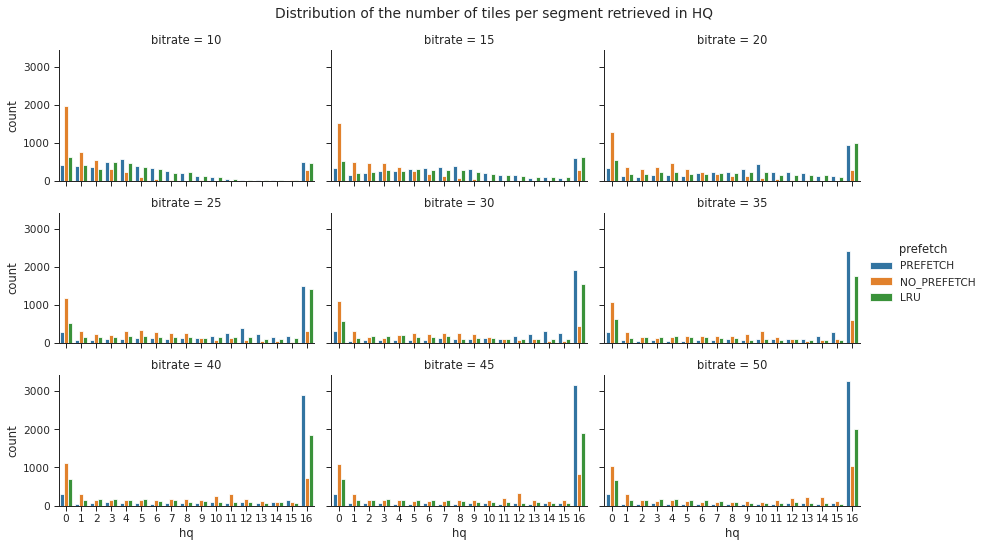

In [27]:
ax = sns.catplot(x="hq", hue="prefetch", data=results_df_filtered, kind="count", height=2.5, aspect=1.602, col='bitrate', col_wrap=3)# ax.axes[0][0].set_xlabel('# HQ tiles')
# ax.axes[0][0].set_title('Distribution of the number of tiles per segment retrieved in HQ\n (Setup: DASH, CTF, spherical walk pred.)')
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Distribution of the number of tiles per segment retrieved in HQ')

Text(0.5, 0.98, 'Distribution of the number of tiles per segment retrieved in HQ')

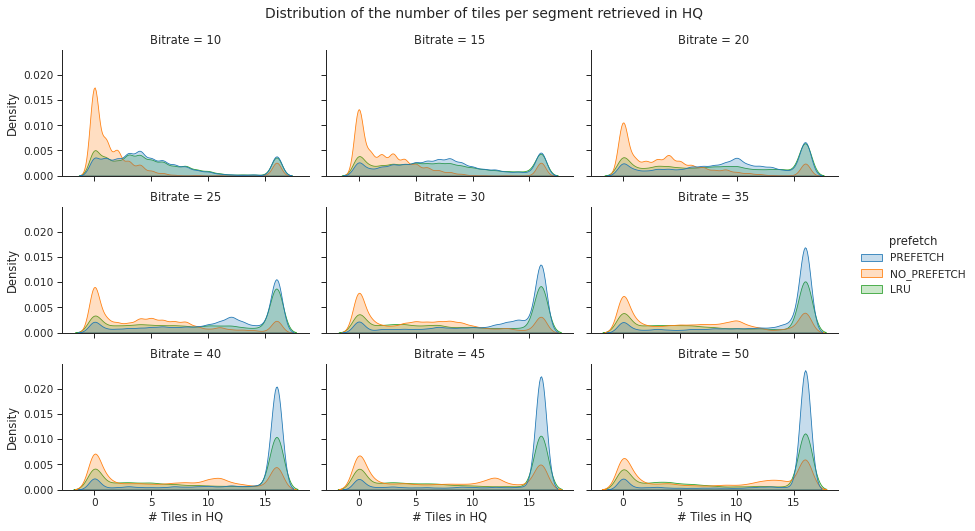

In [28]:
dist_hq_tiles = results_df_filtered[['hq', 'prefetch', 'bitrate']].copy()
dist_hq_tiles.rename(columns={'hq': '# Tiles in HQ', 'bitrate': 'Bitrate'}, inplace=True)

ax = sns.displot(x="# Tiles in HQ", hue="prefetch", data=dist_hq_tiles, height=2.5, aspect=1.602, col='Bitrate', col_wrap=3, kind="kde", fill=True, bw_adjust=.5)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Distribution of the number of tiles per segment retrieved in HQ')

In [29]:
ax.savefig('dist-hq-tiles.pdf', format='pdf', dpi=300, bbox_inches='tight')

Text(0.5, 0.98, 'Distribution of the number of tiles per segment retrieved in HQ')

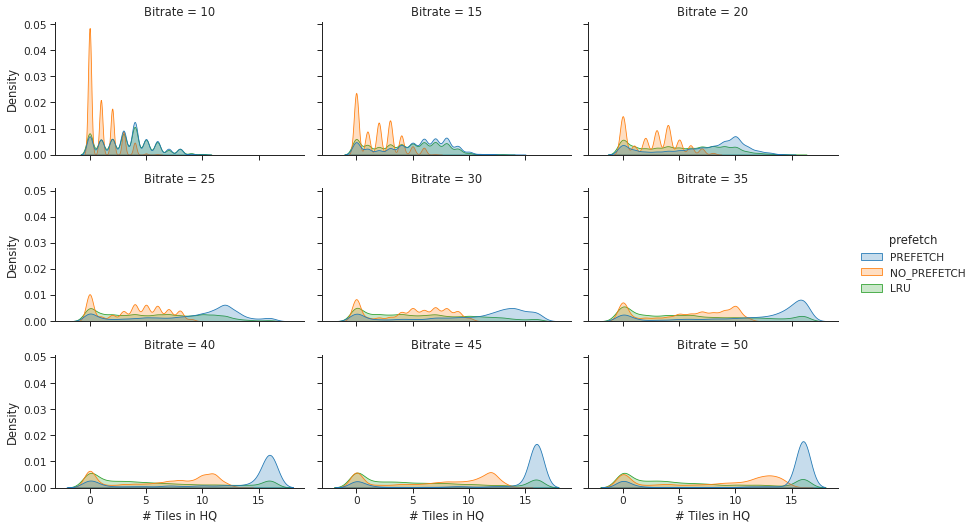

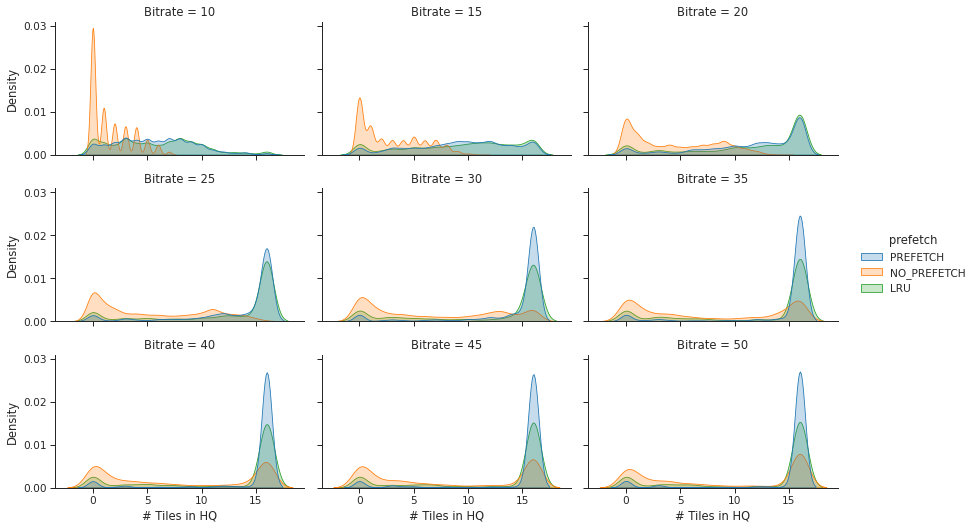

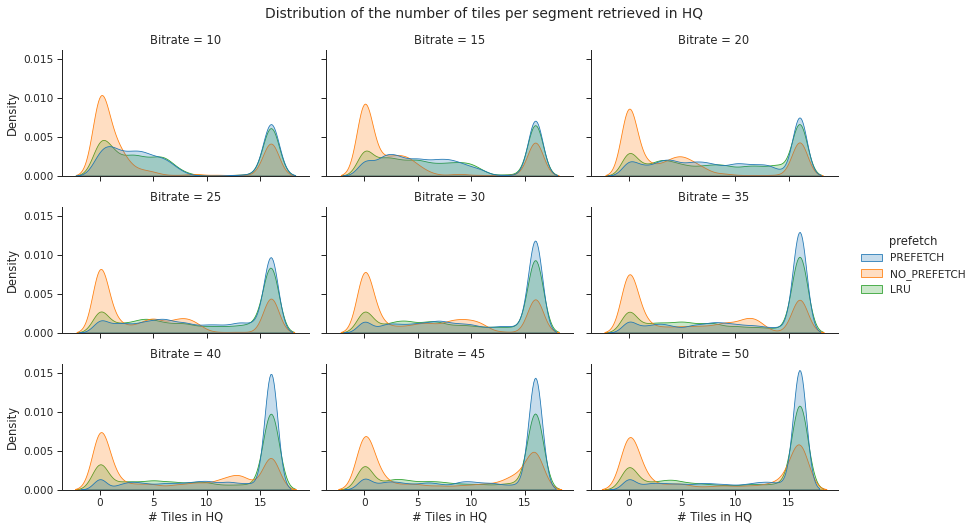

In [30]:
dist_hq_tiles = results_df_filtered[['hq', 'prefetch', 'bitrate', 'video']].copy()
dist_hq_tiles.rename(columns={'hq': '# Tiles in HQ', 'bitrate': 'Bitrate'}, inplace=True)

ax = sns.displot(x="# Tiles in HQ", hue="prefetch", data=dist_hq_tiles[dist_hq_tiles['video']=='Sandwich'], height=2.5, aspect=1.602, col='Bitrate', col_wrap=3, kind="kde", fill=True, bw_adjust=.5)
ax = sns.displot(x="# Tiles in HQ", hue="prefetch", data=dist_hq_tiles[dist_hq_tiles['video']=='Spotlight'], height=2.5, aspect=1.602, col='Bitrate', col_wrap=3, kind="kde", fill=True, bw_adjust=.5)
ax = sns.displot(x="# Tiles in HQ", hue="prefetch", data=dist_hq_tiles[dist_hq_tiles['video']=='Surf'], height=2.5, aspect=1.602, col='Bitrate', col_wrap=3, kind="kde", fill=True, bw_adjust=.5)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Distribution of the number of tiles per segment retrieved in HQ')

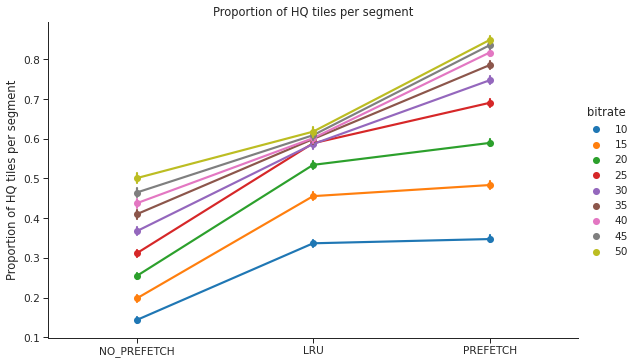

In [31]:
ax = sns.catplot(x="prefetch", y="hq_ratio", 
                 hue="bitrate", data=results_df_filtered, 
                 kind="point", height=5, aspect=1.602, 
                 order=['NO_PREFETCH', 'LRU', 'PREFETCH'])

ax.set(xlabel='', ylabel='Proportion of HQ tiles per segment', title='Proportion of HQ tiles per segment')

Text(0.5, 1.0, 'Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

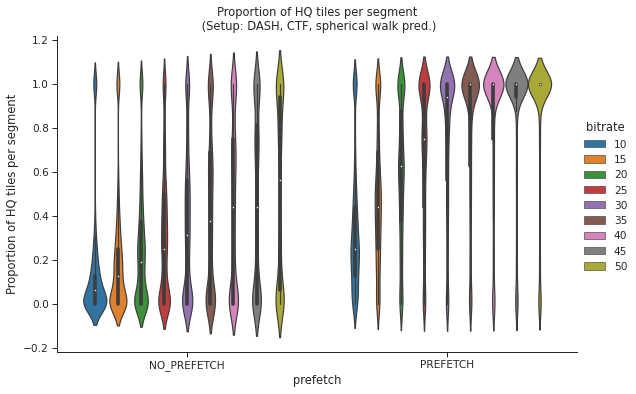

In [32]:
ax = sns.catplot(x="prefetch", y="hq_ratio", hue="bitrate", data=results_df_filtered, kind="violin", height=5, aspect=1.602, order=['NO_PREFETCH', 'PREFETCH'])
ax.axes[0][0].set_ylabel('Proportion of HQ tiles per segment')
ax.axes[0][0].set_title('Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

In [33]:
QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_prefetch.txt'
NP_QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_no_prefetch.txt'
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_{variant}mbps_lpoa_mult'.format(K=K, variant='{variant}')

qualities_list = []
prefetch_flag = False
t_hor = 4
t_vert = 4

for var in VARIANTS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for times_tmpl in [QUALITY_FILE_TMPL, NP_QUALITY_FILE_TMPL]:
                    prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as p_file:
                        p_qualities = [[int(x) for x in json.loads(line)] for line in p_file]
                        p_df = pd.DataFrame(p_qualities, columns=[f'tile_{i}' for i in range(t_hor*t_vert)])
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = v
                        p_df['user'] = u
                        p_df['bitrate'] = var
                        p_df['prefetch'] = 'PREFETCH' if prefetch_flag else f'NO_PREFETCH'
                        qualities_list.append(p_df)
                
qualities_df = pd.concat(qualities_list, ignore_index=True)

In [34]:
qualities_df

,tile_0,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,...,tile_11,tile_12,tile_13,tile_14,tile_15,segment,video,user,bitrate,prefetch
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,13,10,PREFETCH
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,2,0,13,10,PREFETCH
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,3,0,13,10,PREFETCH
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,4,0,13,10,PREFETCH
4,1,2,2,1,1,2,1,1,1,1,...,1,1,1,1,1,5,0,13,10,PREFETCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77755,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,26,4,48,50,NO_PREFETCH
77756,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,27,4,48,50,NO_PREFETCH
77757,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,28,4,48,50,NO_PREFETCH
77758,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,29,4,48,50,NO_PREFETCH


In [35]:
def plot_quality_heatmap(u_id, v_id, truncate=len(VARIANTS)):
    fig, axes = plt.subplots(len(VARIANTS[:truncate]), 2, figsize=(18, int(40*(truncate/9))), sharey=True)

    for i in range(0,len(VARIANTS[:truncate])):
        for j in range(2):
            ax = axes[i][j]
            sns.heatmap(
                data = qualities_df[
                    (qualities_df['user'] == u_id) & 
                    (qualities_df['video'] == v_id) &
                    (qualities_df['prefetch'] == ('NO_PREFETCH' if j == 0 else 'PREFETCH')) &
                    (qualities_df['bitrate'] == VARIANTS[i])
                    ][['segment']+[f'tile_{t}' for t in range(t_hor*t_vert)]].set_index('segment').T, 
                linewidths=.1, 
                cmap="Blues",
                vmin=1.,
                vmax=2.,
                ax=ax)
            if i == 0:
                ax.set_title(f'Requested quality per tile ({"NO_PREFETCH" if j == 0 else "PREFETCH"})')
            ax.set_xlabel('Segment')
            ax.set_ylabel(f'{VARIANTS[i]}Mbps')
    return fig, axes

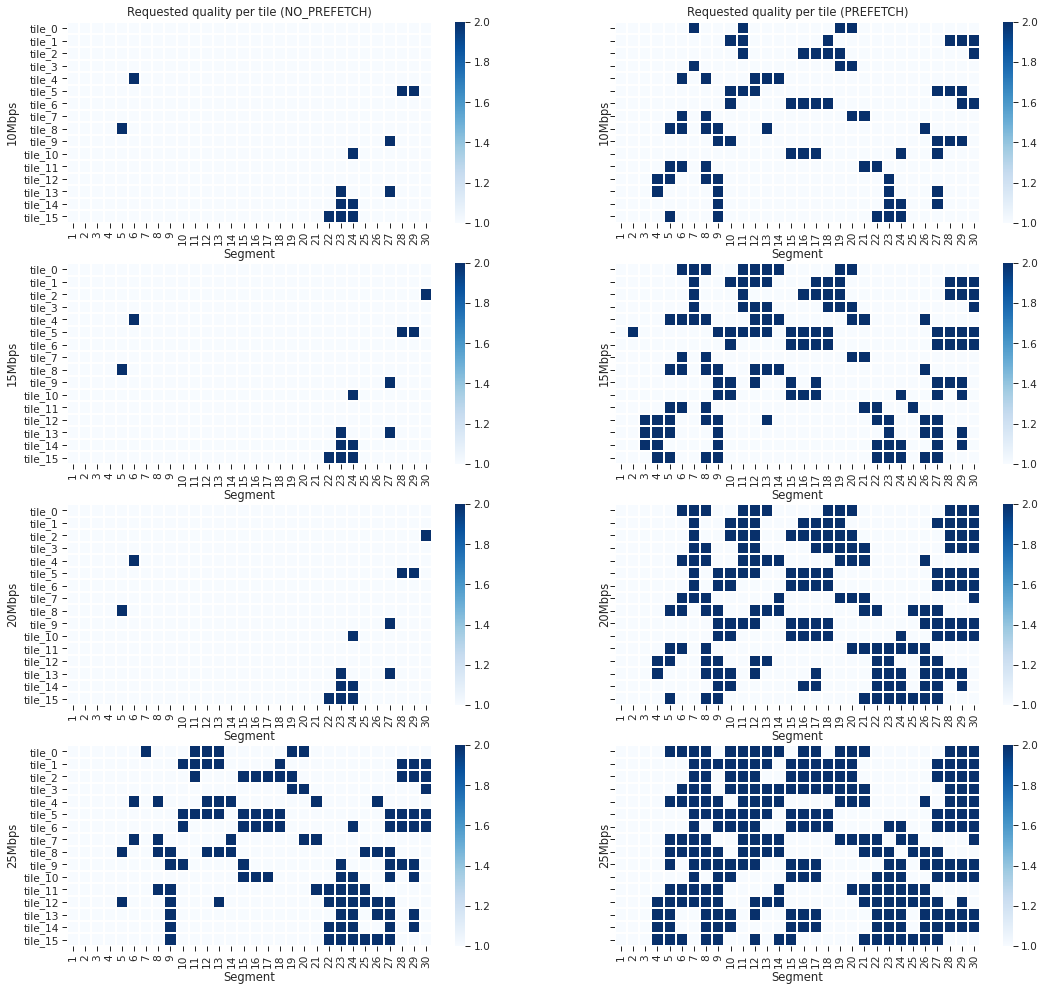

In [36]:
u_id = 25
v_id = 0

fig, _ = plot_quality_heatmap(u_id, v_id, truncate=4)

In [37]:
fig.savefig('quality-heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')

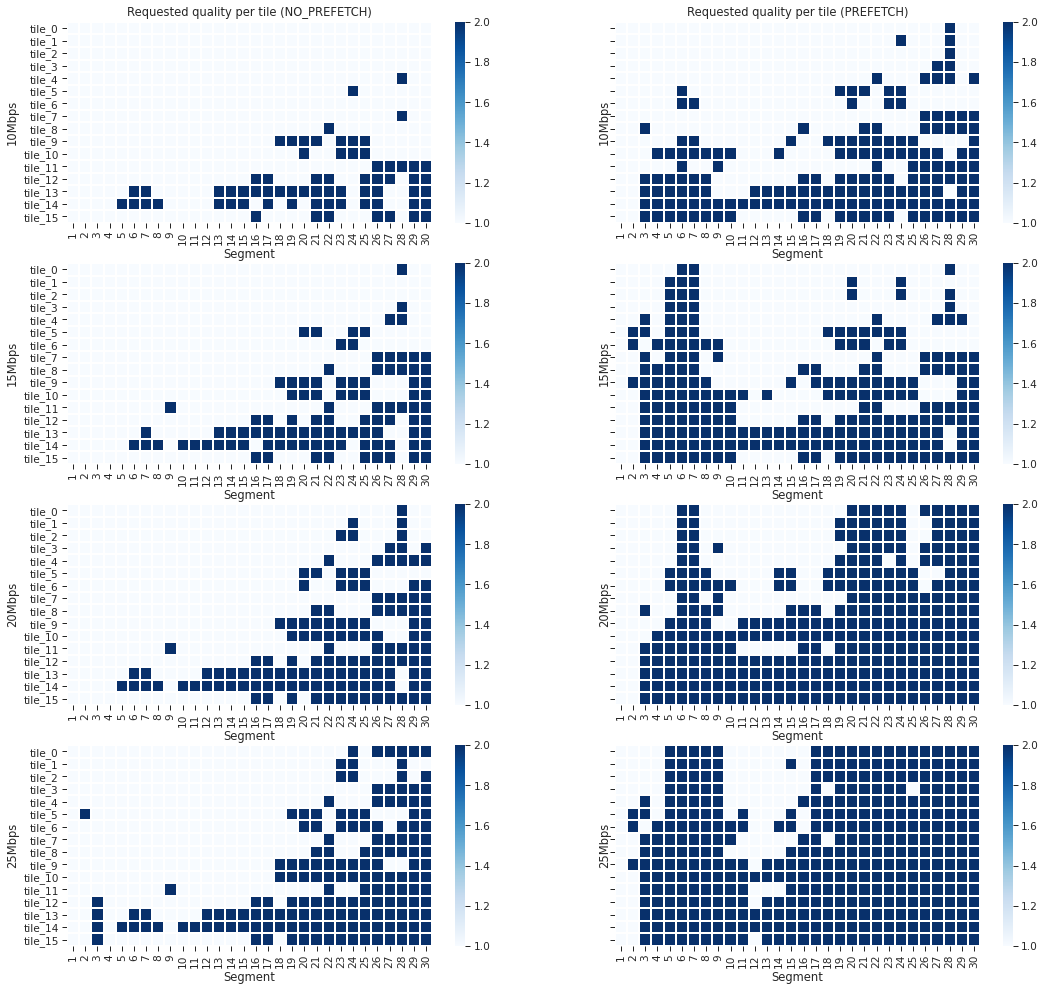

In [38]:
v_id = 2

fig, _ = plot_quality_heatmap(u_id, v_id, truncate=4)

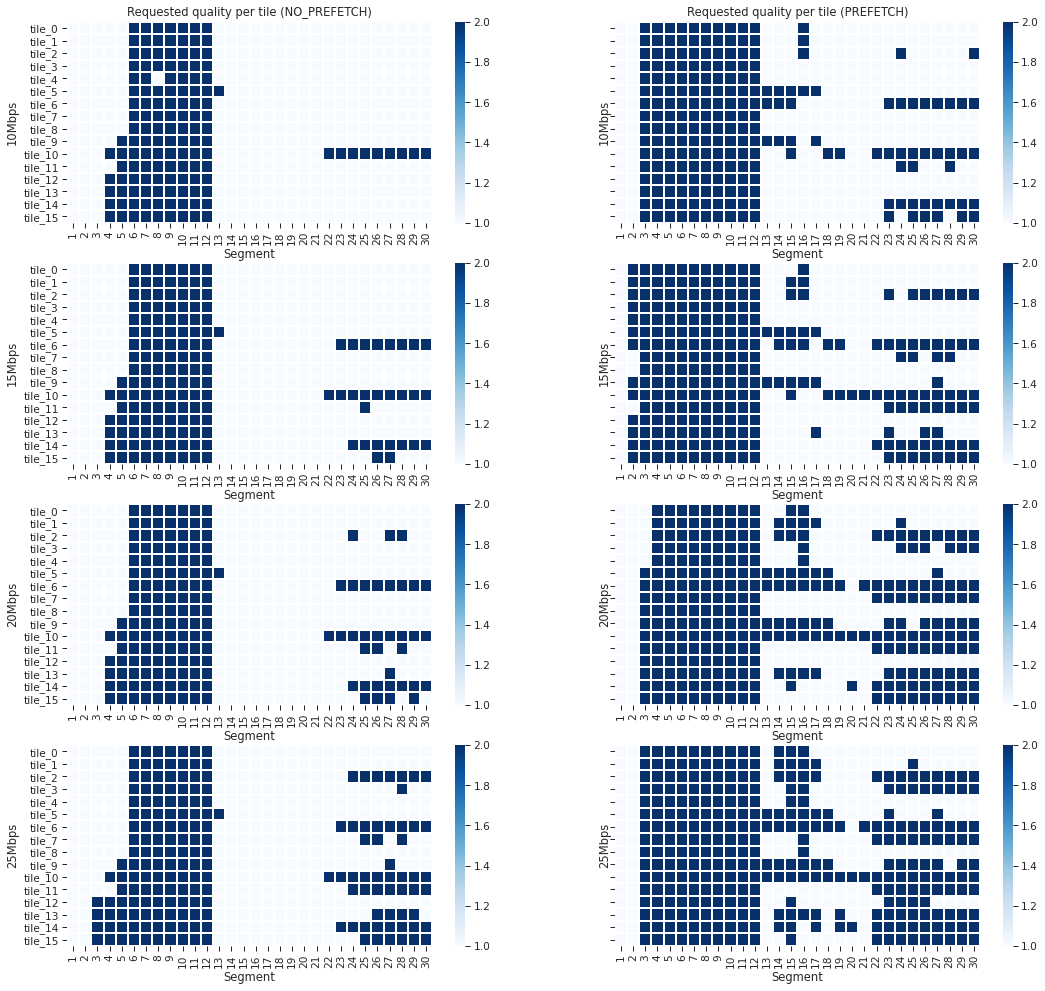

In [39]:
v_id = 4

fig, _ = plot_quality_heatmap(u_id, v_id, truncate=4)

<AxesSubplot:xlabel='hq', ylabel='Proportion'>

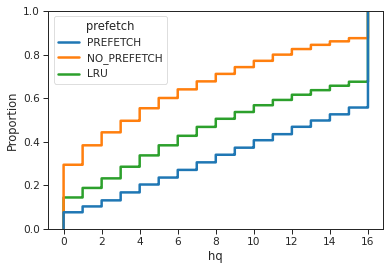

In [40]:
sns.ecdfplot(data=results_df_filtered, 
            x="hq", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True
)

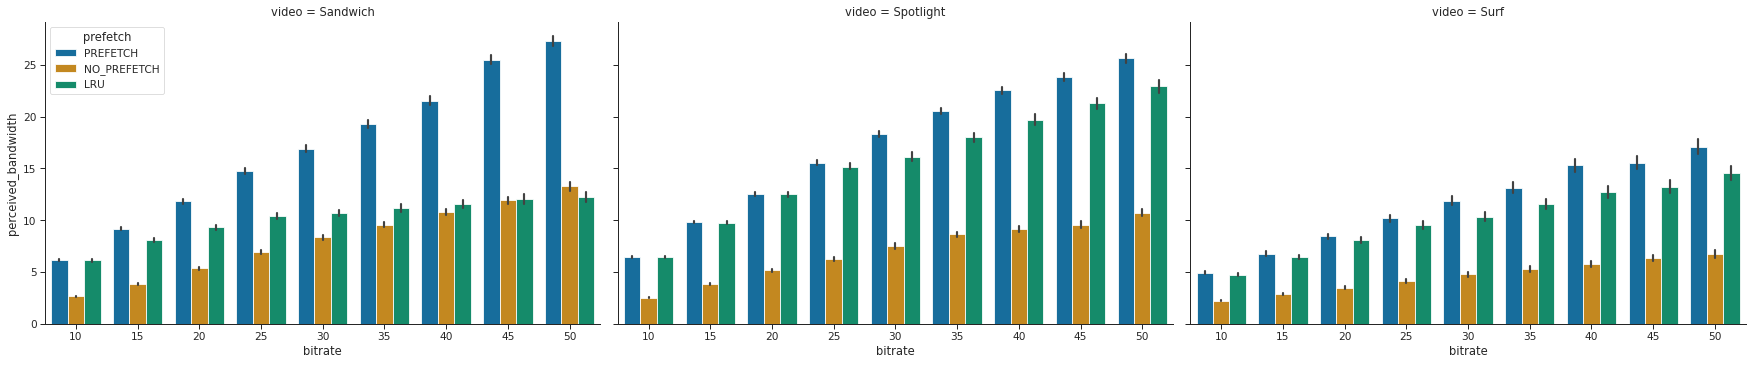

In [41]:
g = sns.catplot(x="bitrate", y="perceived_bandwidth", 
            kind="bar", palette='colorblind',
            hue='prefetch', data=results_df_filtered, 
            height=5, aspect=1.618,# showfliers=False,
            legend_out=False, col='video')

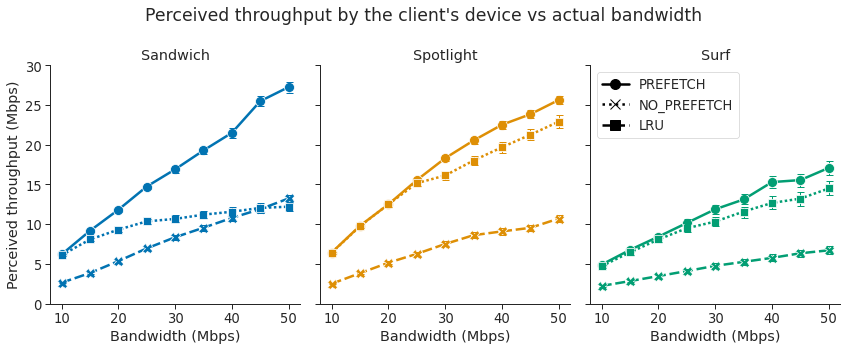

In [72]:
g = sns.relplot(x="bitrate", y="perceived_bandwidth", 
            kind="line", palette='colorblind', col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=99, markers=True, style='prefetch', hue='video', linewidth=2.5,
            data=results_df_filtered, height=5, aspect=0.8, legend=False)#facet_kws = {'legend_out': True})

for i, ax in enumerate(g.axes.flat):
    ax.set_title(v_unique[i])

g.set(ylim=(0,30), ylabel='Perceived throughput (Mbps)', xlabel='Bandwidth (Mbps)')
# leg = g._legend
# leg.set_bbox_to_anchor([1,0.8])

plt.legend(title='', loc='upper left', labels=['PREFETCH', 'NO_PREFETCH', 'LRU'])

leg = g.axes[0][2].get_legend()
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=2.5, label='PREFETCH'),
                   Line2D([0], [0], marker='x', color='k', lw=2.5, ls=':', label='NO_PREFETCH', markerfacecolor='k'),
                   Line2D([0], [0], marker='s', color='k', lw=2.5, ls='--', label='LRU', markerfacecolor='k')
                  ]
g.axes[0][2].legend(handles=legend_elements, loc='upper left')

plt.suptitle('Perceived throughput by the client\'s device vs actual bandwidth')
plt.tight_layout()

In [73]:
g.savefig('perceived-bitrate.pdf', format='pdf', dpi=300, bbox_inches='tight')

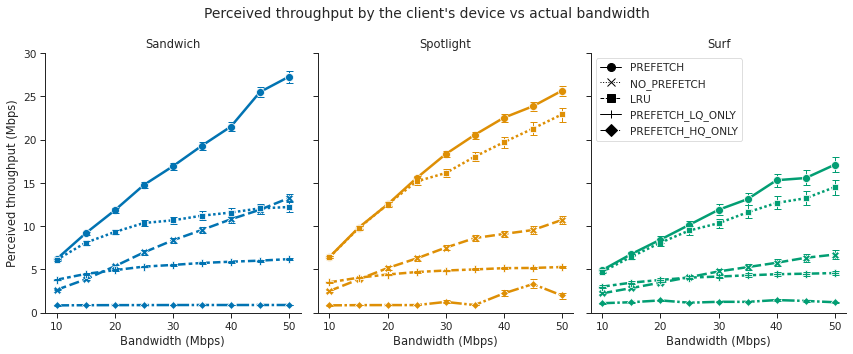

In [42]:
g = sns.relplot(x="bitrate", y="perceived_bandwidth", 
            kind="line", palette='colorblind', col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=99, markers=True, style='prefetch', hue='video', linewidth=2.5,
            data=results_df, height=5, aspect=0.8, legend=False)#facet_kws = {'legend_out': True})

for i, ax in enumerate(g.axes.flat):
    ax.set_title(v_unique[i])

g.set(ylim=(0,30), ylabel='Perceived throughput (Mbps)', xlabel='Bandwidth (Mbps)')
# leg = g._legend
# leg.set_bbox_to_anchor([1,0.8])

plt.legend(title='', loc='upper left', labels=['PREFETCH', 'NO_PREFETCH', 'LRU', 'PREFETCH_LQ_ONLY', 'PREFETCH_HQ_ONLY'])

leg = g.axes[0][2].get_legend()
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=1, label='PREFETCH'),
                   Line2D([0], [0], marker='x', color='k', lw=1, ls=':', label='NO_PREFETCH', markerfacecolor='k'),
                   Line2D([0], [0], marker='s', color='k', lw=1, ls='--', label='LRU', markerfacecolor='k'),
                   Line2D([0], [0], marker='+', color='k', lw=1, ls='-', label='PREFETCH_LQ_ONLY', markerfacecolor='k'),
                   Line2D([0], [0], marker='D', color='k', lw=1, ls='-.', label='PREFETCH_HQ_ONLY', markerfacecolor='k')
                  ]
g.axes[0][2].legend(handles=legend_elements, loc='upper left')

plt.suptitle('Perceived throughput by the client\'s device vs actual bandwidth')
plt.tight_layout()

In [43]:
g.savefig('perceived-bitrate.pdf', format='pdf', dpi=300, bbox_inches='tight')

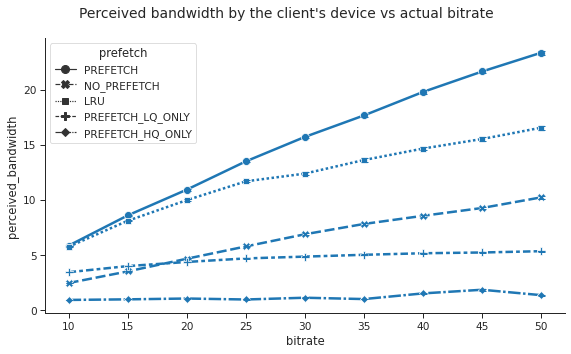

In [44]:
g = sns.relplot(x="bitrate", y="perceived_bandwidth", 
            kind="line", palette='colorblind',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=68, markers=True, style='prefetch', linewidth=2.5,
            data=results_df, height=5, aspect=1.618, facet_kws = {'legend_out': False})

# for i, ax in enumerate(g.axes.flat):
#     ax.set_title(v_unique[i])

# g.set(ylim=(0,30), ylabel='Perceived bandwidth (Mbps)', xlabel='Bitrate (Mbps)')
# # leg = g._legend
# # leg.set_bbox_to_anchor([1,0.8])

# plt.legend(title='', loc='upper left', labels=['PREFETCH', 'NO_PREFETCH', 'LRU'])

# leg = g.axes[0][2].get_legend()
# legend_elements = [Line2D([0], [0], marker='o', color='k', lw=2, label='PREFETCH'),
#                    Line2D([0], [0], marker='x', color='k', lw=2, ls=':', label='LRU', markerfacecolor='k'),
#                    Line2D([0], [0], marker='s', color='k', lw=2, ls='--', label='NO_PREFETCH', markerfacecolor='k')
#                   ]
# g.axes[0][2].legend(handles=legend_elements, loc='upper left')
    

plt.suptitle('Perceived bandwidth by the client\'s device vs actual bitrate')
plt.tight_layout()

In [45]:
g.savefig('perceived-bitrate-avg.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [46]:
perceived_bw_df = results_df[['video', 'bitrate', 'prefetch', 'perceived_bandwidth']].groupby(['video', 'prefetch', 'bitrate']).mean().reset_index()
perceived_bw_df.head()

,video,prefetch,bitrate,perceived_bandwidth
0,Sandwich,LRU,10,6.088920
1,Sandwich,LRU,15,8.070203
2,Sandwich,LRU,20,9.305944
3,Sandwich,LRU,25,10.350646
4,Sandwich,LRU,30,10.659796


In [47]:
perceived_bw_df.pivot(index=['bitrate'], columns=['prefetch', 'video'], values='perceived_bandwidth')

prefetch,LRU,NO_PREFETCH,PREFETCH,PREFETCH_HQ_ONLY,PREFETCH_LQ_ONLY,LRU,NO_PREFETCH,PREFETCH,PREFETCH_HQ_ONLY,PREFETCH_LQ_ONLY,LRU,NO_PREFETCH,PREFETCH,PREFETCH_HQ_ONLY,PREFETCH_LQ_ONLY
video,Sandwich,Sandwich,Sandwich,Sandwich,Sandwich,Spotlight,Spotlight,Spotlight,Spotlight,Spotlight,Surf,Surf,Surf,Surf,Surf
bitrate,,,,,,,,,,,,,,,
10,6.088920,2.619938,6.178278,0.823596,3.788556,6.397107,2.491021,6.422488,0.825507,3.490256,4.714176,2.220080,4.904557,1.076190,2.991990
15,8.070203,3.839825,9.163399,0.843986,4.457337,9.748802,3.822746,9.799691,0.852576,4.027600,6.451222,2.826614,6.763828,1.189595,3.451083
20,9.305944,5.342324,11.814316,0.852120,4.897750,12.503508,5.140871,12.500132,0.858852,4.393496,8.073838,3.455279,8.428750,1.398329,3.768528
25,10.350646,6.944886,14.742304,0.856559,5.306094,15.163279,6.254166,15.549168,0.856166,4.680732,9.489851,4.091438,10.151120,1.132283,4.040431
30,10.659796,8.350720,16.908596,0.864113,5.502857,16.131933,7.500166,18.316173,1.223627,4.856990,10.324768,4.748646,11.877488,1.237307,4.155634
35,11.199612,9.548322,19.291767,0.868033,5.729302,18.019434,8.607971,20.544935,0.862952,4.982086,11.585997,5.249566,13.113405,1.230285,4.299711
40,11.563444,10.783332,21.508914,0.865229,5.876877,19.688741,9.086528,22.524762,2.204053,5.128206,12.674379,5.752532,15.302769,1.437029,4.427706
45,12.045233,11.886717,25.499803,0.868843,5.996859,21.266779,9.535177,23.849463,3.289081,5.154264,13.218371,6.331202,15.553142,1.338244,4.488390


In [48]:
prefetch_perceived_bw = perceived_bw_df[perceived_bw_df['prefetch'].isin(['NO_PREFETCH', 'PREFETCH'])].pivot(index=['bitrate'], columns=['prefetch', 'video'], values='perceived_bandwidth')#.pct_change(axis=1)[['PREFETCH']]*100)#.plot(kind='bar')
(prefetch_perceived_bw['PREFETCH']/prefetch_perceived_bw['NO_PREFETCH']).mean()

video
Sandwich     2.147114
Spotlight    2.473893
Surf         2.465398
dtype: float64

In [49]:
lru_perceived_bw = perceived_bw_df[perceived_bw_df['prefetch'].isin(['NO_PREFETCH', 'LRU'])].pivot(index=['bitrate'], columns=['prefetch', 'video'], values='perceived_bandwidth')#.pct_change(axis=1)[['LRU']]*100)#.plot(kind='bar')
lru_perceived_bw['LRU']/lru_perceived_bw['NO_PREFETCH']

video,Sandwich,Spotlight,Surf
bitrate,,,
10,2.324071,2.568066,2.123426
15,2.101711,2.550210,2.282314
20,1.741928,2.432177,2.336667
25,1.490398,2.424509,2.319441
30,1.276512,2.150877,2.174255
35,1.172940,2.093343,2.207039
40,1.072344,2.166806,2.203270
45,1.013336,2.230350,2.087814
50,0.921329,2.141075,2.163015


In [50]:
(((prefetch_perceived_bw['PREFETCH']-lru_perceived_bw['LRU'])/lru_perceived_bw['LRU'])*100)#.mean()

video,Sandwich,Spotlight,Surf
bitrate,,,
10,1.467551,0.396757,4.038480
15,13.546077,0.521997,4.845681
20,26.954524,-0.027000,4.395820
25,42.428836,2.544887,6.968166
30,58.620251,13.539850,15.038788
35,72.253890,14.015431,13.183219
40,86.007852,14.404278,20.737816
45,111.700370,12.144220,17.663078
50,123.600786,11.932713,17.893052


In [51]:
(prefetch_perceived_bw['PREFETCH']/lru_perceived_bw['LRU']).mean()

video
Sandwich     1.596200
Spotlight    1.077192
Surf         1.116405
dtype: float64

In [52]:
perceived_bw_avg_df = results_df_filtered[['bitrate', 'prefetch', 'perceived_bandwidth']].groupby(['prefetch', 'bitrate']).mean().reset_index()
perceived_bw_avg_df

,prefetch,bitrate,perceived_bandwidth
0,LRU,10,5.733401
1,LRU,15,8.090076
2,LRU,20,9.961097
3,LRU,25,11.667925
4,LRU,30,12.372166
5,LRU,35,13.601681
6,LRU,40,14.642188
7,LRU,45,15.510128
8,LRU,50,16.535759
9,NO_PREFETCH,10,2.443680


In [53]:
pivot_perceived_bw_avg = perceived_bw_avg_df.pivot(index=['bitrate'], columns=['prefetch'], values='perceived_bandwidth')
pivot_perceived_bw_avg

prefetch,LRU,NO_PREFETCH,PREFETCH
bitrate,,,
10,5.733401,2.443680,5.835108
15,8.090076,3.496395,8.575639
20,9.961097,4.646158,10.914400
25,11.667925,5.763497,13.480864
30,12.372166,6.866511,15.700752
35,13.601681,7.801953,17.650036
40,14.642188,8.540798,19.778815
45,15.510128,9.251032,21.634136
50,16.535759,10.214682,23.337938


In [54]:
(pivot_perceived_bw_avg['PREFETCH']/pivot_perceived_bw_avg['NO_PREFETCH'])

bitrate
10    2.387836
15    2.452709
20    2.349124
25    2.339008
30    2.286569
35    2.262259
40    2.315804
45    2.338565
50    2.284744
dtype: float64

In [55]:
(pivot_perceived_bw_avg['PREFETCH']/pivot_perceived_bw_avg['LRU'])

bitrate
10    1.017739
15    1.060020
20    1.095703
25    1.155378
30    1.269038
35    1.297636
40    1.350810
45    1.394839
50    1.411362
dtype: float64

In [56]:
network_df = pd.read_csv('./backhaul-traffic.csv')
network_df

,Bitrate,NO_PREFETCH,LRU,PREFETCH
0,10,1.11,0.27,0.71
1,15,1.64,0.35,0.91
2,20,2.24,0.44,1.16
3,25,2.82,0.50,1.30
4,30,3.43,0.66,1.23
5,35,3.89,0.71,1.37
6,40,4.24,0.75,1.38
7,45,4.57,0.77,0.87
8,50,5.01,0.79,0.85


Text(0.5, 1.0, 'Network traffic between Content Server and Prefetch Server')

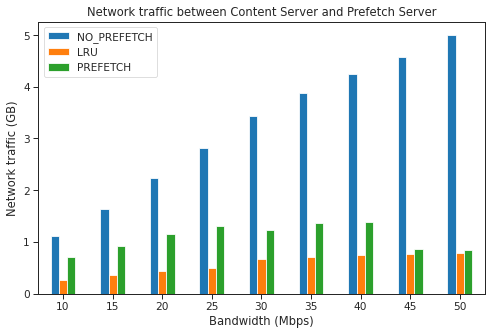

In [57]:
ax = network_df.plot(kind='bar', x='Bitrate', rot=0, figsize=(8,5))
ax.set_ylabel('Network traffic (GB)')
ax.set_xlabel('Bandwidth (Mbps)')
plt.title('Network traffic between Content Server and Prefetch Server')

In [58]:
ax.figure.savefig('backhaul-traffic.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [59]:
hq_lq_df = results_df_filtered[['video', 'bitrate', 'prefetch', 'hq', 'lq']].groupby(['video', 'prefetch', 'bitrate']).mean().reset_index()
avg_hq_lq_df = hq_lq_df.groupby(['bitrate', 'prefetch']).mean().reset_index()
pivot_avg_hq_lq_df = avg_hq_lq_df.pivot(index=['bitrate'], columns=['prefetch'], values='hq')
pivot_avg_hq_lq_df

prefetch,LRU,NO_PREFETCH,PREFETCH
bitrate,,,
10,5.387500,2.295833,5.557870
15,7.286343,3.163889,7.733333
20,8.546296,4.068750,9.429398
25,9.417361,4.981944,11.044213
30,9.385648,5.872454,11.952546
35,9.587269,6.556944,12.564120
40,9.621759,6.998611,13.070602
45,9.741435,7.430324,13.365278
50,9.884491,8.011111,13.575463


In [60]:
avg_hq_lq_df

,bitrate,prefetch,hq,lq
0,10,LRU,5.387500,10.612500
1,10,NO_PREFETCH,2.295833,13.704167
2,10,PREFETCH,5.557870,10.442130
3,15,LRU,7.286343,8.713657
4,15,NO_PREFETCH,3.163889,12.836111
5,15,PREFETCH,7.733333,8.266667
6,20,LRU,8.546296,7.453704
7,20,NO_PREFETCH,4.068750,11.931250
8,20,PREFETCH,9.429398,6.570602
9,25,LRU,9.417361,6.582639


In [61]:
network_df_melt = pd.melt(network_df, id_vars=['Bitrate'], value_vars=['NO_PREFETCH', 'LRU', 'PREFETCH'], var_name='prefetch', value_name='network_traffic')
network_df_melt

,Bitrate,prefetch,network_traffic
0,10,NO_PREFETCH,1.11
1,15,NO_PREFETCH,1.64
2,20,NO_PREFETCH,2.24
3,25,NO_PREFETCH,2.82
4,30,NO_PREFETCH,3.43
5,35,NO_PREFETCH,3.89
6,40,NO_PREFETCH,4.24
7,45,NO_PREFETCH,4.57
8,50,NO_PREFETCH,5.01
9,10,LRU,0.27


In [62]:
merged_quality_network_df = pd.merge(avg_hq_lq_df, network_df_melt,  how='left', left_on=['bitrate','prefetch'], right_on = ['Bitrate','prefetch'])[['bitrate', 'prefetch', 'hq', 'network_traffic']]
merged_quality_network_df = merged_quality_network_df.rename(columns={
    'bitrate': 'bandwidth',
    'prefetch': 'setup',
    'hq': 'hq_tiles'
})
merged_quality_network_df['setup'] = merged_quality_network_df['setup'].astype('category')
merged_quality_network_df['setup_cat'] = merged_quality_network_df['setup'].cat.codes
merged_quality_network_df

,bandwidth,setup,hq_tiles,network_traffic,setup_cat
0,10,LRU,5.387500,0.27,0
1,10,NO_PREFETCH,2.295833,1.11,1
2,10,PREFETCH,5.557870,0.71,2
3,15,LRU,7.286343,0.35,0
4,15,NO_PREFETCH,3.163889,1.64,1
5,15,PREFETCH,7.733333,0.91,2
6,20,LRU,8.546296,0.44,0
7,20,NO_PREFETCH,4.068750,2.24,1
8,20,PREFETCH,9.429398,1.16,2
9,25,LRU,9.417361,0.50,0


In [63]:
merged_quality_network_df[merged_quality_network_df['setup'] == 'PREFETCH']

,bandwidth,setup,hq_tiles,network_traffic,setup_cat
2,10,PREFETCH,5.557870,0.71,2
5,15,PREFETCH,7.733333,0.91,2
8,20,PREFETCH,9.429398,1.16,2
11,25,PREFETCH,11.044213,1.30,2
14,30,PREFETCH,11.952546,1.23,2
17,35,PREFETCH,12.564120,1.37,2
20,40,PREFETCH,13.070602,1.38,2
23,45,PREFETCH,13.365278,0.87,2
26,50,PREFETCH,13.575463,0.85,2


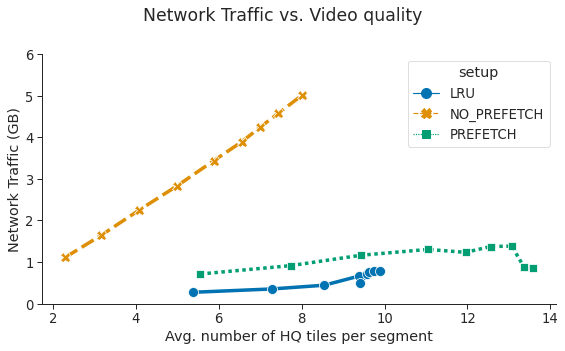

In [64]:
sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.5, rc={'lines.markersize': 10})
g = sns.relplot(y="network_traffic", x="hq_tiles", 
            kind="line", palette='colorblind',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=68, markers=True, style='setup', hue='setup', linewidth=3.5,
#             data=merged_quality_network_df[merged_quality_network_df['prefetch'] != 'NO_PREFETCH'], 
            data=merged_quality_network_df,
            height=5, aspect=1.618, facet_kws = {'legend_out': False})

g.set(ylim=(0,6), ylabel='Network Traffic (GB)', xlabel='Avg. number of HQ tiles per segment')

plt.suptitle('Network Traffic vs. Video quality')
plt.tight_layout()

<AxesSubplot:xlabel='hq_tiles', ylabel='network_traffic'>

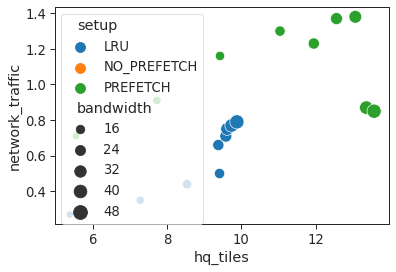

In [65]:
sns.scatterplot(y="network_traffic", x="hq_tiles", hue='setup', size="bandwidth",
            data=merged_quality_network_df[merged_quality_network_df['setup'] != 'NO_PREFETCH'])

<AxesSubplot:>

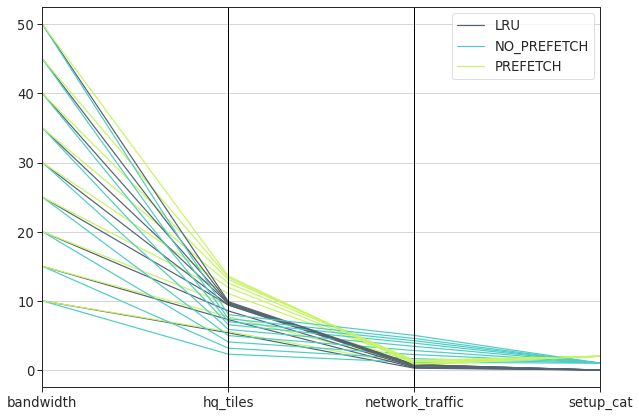

In [66]:
fig, ax = plt.subplots(figsize=(10,7))
pd.plotting.parallel_coordinates(merged_quality_network_df, 'setup', color=('#556270', '#4ECDC4', '#C7F464'), ax=ax)

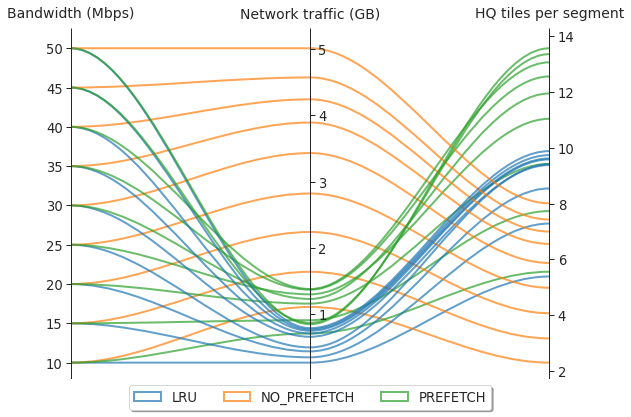

In [67]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
from sklearn import datasets

# iris = datasets.load_iris()
# ynames = iris.feature_names
ynames = ['bandwidth', 'network_traffic', 'hq_tiles']
ylabels = ['Bandwidth (Mbps)', 'Network traffic (GB)', 'HQ tiles per segment']
# ys = iris.data
ys = merged_quality_network_df[ynames].to_numpy()
ys_target = merged_quality_network_df['setup_cat'].to_numpy()
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

# ymaxs[1], ymins[1] = ymins[1], ymaxs[1]  # reverse axis 1 to have less crossings
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(9,6))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ylabels, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Parallel Coordinates Plot\nBandwidth, Network Traffic, and Video quality', fontsize=18, pad=12)

colors = plt.cm.tab10.colors
legend_handles = [None for _ in merged_quality_network_df['setup'].unique()]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[ys_target[j]])
    legend_handles[ys_target[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, merged_quality_network_df['setup'].unique(), #iris.target_names,
            loc='lower center', bbox_to_anchor=(0.5, -0.11),
            ncol=merged_quality_network_df['setup'].nunique(), fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

In [68]:
fig.savefig('bw-nwt-vq.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [69]:
iris.target

NameError: name 'iris' is not defined